# FineTuning BERT for Multi-Class Classification with custom datasets

### [Link to Dataset](https://www.kaggle.com/datasets/savasy/ttc4900)

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cpu'

In [3]:


df_org= pd.read_csv("dark_patterns.csv")

df_org.dropna(subset=['Pattern String'], inplace=True)


df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,Pattern String,Comment,Pattern Category,Pattern Type,Where in website?,Deceptive?,Website Page
1164,Only 4 left in stock,Product detail,Scarcity,Low-stock Message,Product Page,No,https://shop.ugmonk.com/products/7th-anniversa...
839,Items reserved for 15:00,Cart empties,Urgency,Countdown Timer,Cart Page,No,https://www.therealreal.com/
1644,Only 2 left!,Product detail,Scarcity,Low-stock Message,Product Page,No,https://www.urbandecay.com/brow-blade-urban-de...
1199,"HURRY, THERE ARE ONLY 9 ITEM(S) LEFT!",Product detail,Scarcity,Low-stock Message,Product Page,No,https://us.geekstore.com/collections/best-sell...
303,Last purchased at 11:19am today.,On the product image,Social Proof,Activity Notification,Product Page,No,https://www.very.co.uk/aruba-outdoor-2-seatern...


In [4]:
labels = df_org['Pattern Category'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Scarcity',
 'Urgency',
 'Social Proof',
 'Misdirection',
 'Obstruction',
 'Forced Action',
 'Sneaking']

In [5]:
for key, value in enumerate(labels):
    print(value)

Scarcity
Urgency
Social Proof
Misdirection
Obstruction
Forced Action
Sneaking


In [6]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [7]:
label2id

{'Scarcity': 0,
 'Urgency': 1,
 'Social Proof': 2,
 'Misdirection': 3,
 'Obstruction': 4,
 'Forced Action': 5,
 'Sneaking': 6}

In [8]:
id2label

{0: 'Scarcity',
 1: 'Urgency',
 2: 'Social Proof',
 3: 'Misdirection',
 4: 'Obstruction',
 5: 'Forced Action',
 6: 'Sneaking'}

In [10]:
df_org.head()

,Pattern String,Comment,Pattern Category,Pattern Type,Where in website?,Deceptive?,Website Page
1164,Only 4 left in stock,Product detail,Scarcity,Low-stock Message,Product Page,No,https://shop.ugmonk.com/products/7th-anniversa...
839,Items reserved for 15:00,Cart empties,Urgency,Countdown Timer,Cart Page,No,https://www.therealreal.com/
1644,Only 2 left!,Product detail,Scarcity,Low-stock Message,Product Page,No,https://www.urbandecay.com/brow-blade-urban-de...
1199,"HURRY, THERE ARE ONLY 9 ITEM(S) LEFT!",Product detail,Scarcity,Low-stock Message,Product Page,No,https://us.geekstore.com/collections/best-sell...
303,Last purchased at 11:19am today.,On the product image,Social Proof,Activity Notification,Product Page,No,https://www.very.co.uk/aruba-outdoor-2-seatern...


In [11]:
# df_org['labels_num'] = pd.factorize(df_org.category)[0]
# df_org.head()

In [12]:
df_org["labels"] = df_org["Pattern Category"].map(lambda x: label2id[x.strip()])


In [13]:
df_org.head()

,Pattern String,Comment,Pattern Category,Pattern Type,Where in website?,Deceptive?,Website Page,labels
1164,Only 4 left in stock,Product detail,Scarcity,Low-stock Message,Product Page,No,https://shop.ugmonk.com/products/7th-anniversa...,0
839,Items reserved for 15:00,Cart empties,Urgency,Countdown Timer,Cart Page,No,https://www.therealreal.com/,1
1644,Only 2 left!,Product detail,Scarcity,Low-stock Message,Product Page,No,https://www.urbandecay.com/brow-blade-urban-de...,0
1199,"HURRY, THERE ARE ONLY 9 ITEM(S) LEFT!",Product detail,Scarcity,Low-stock Message,Product Page,No,https://us.geekstore.com/collections/best-sell...,0
303,Last purchased at 11:19am today.,On the product image,Social Proof,Activity Notification,Product Page,No,https://www.very.co.uk/aruba-outdoor-2-seatern...,2


<Axes: ylabel='Pattern Category'>

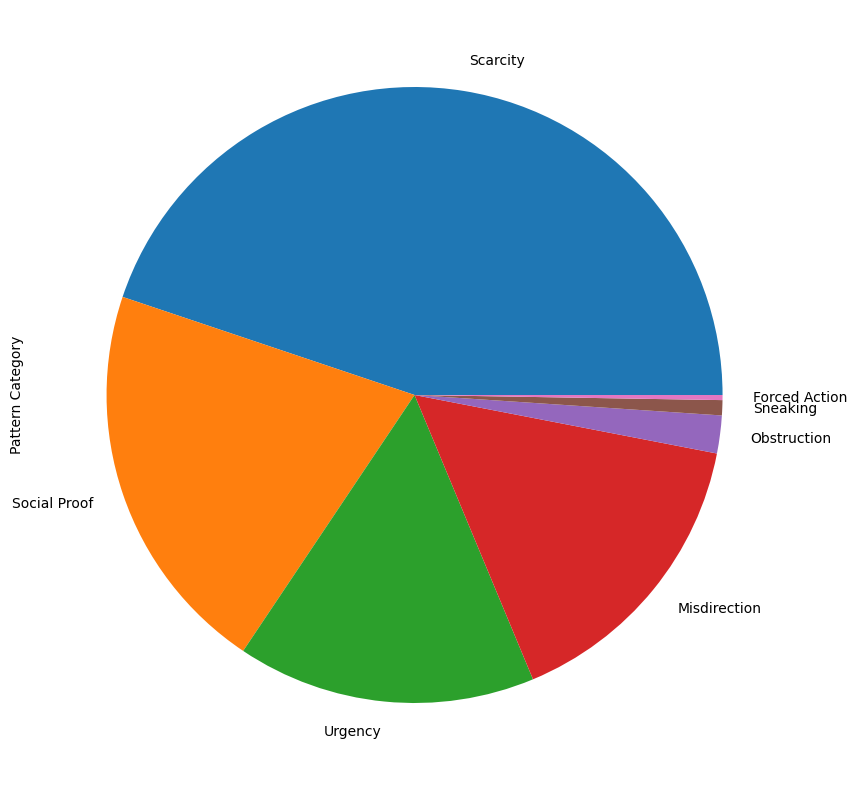

In [14]:
df_org["Pattern Category"].value_counts().plot(kind='pie', figsize=(10,10))

## Splitting df_org


In [17]:
SIZE = df_org.shape[0]

train_texts = list(df_org["Pattern String"][:SIZE//2])
val_texts = list(df_org["Pattern String"][SIZE//2:(3*SIZE)//4])
test_texts = list(df_org["Pattern String"][(3*SIZE)//4:])

train_labels = list(df_org.labels[:SIZE//2])
val_labels = list(df_org.labels[SIZE//2:(3*SIZE)//4])
test_labels = list(df_org.labels[(3*SIZE)//4:])


In [21]:
len(train_texts)


756

In [22]:
len(train_texts), len(val_texts), len(test_texts)

(756, 378, 378)

In [23]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [24]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
 
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
 
        return len(self.labels)


In [25]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [26]:
from transformers import TrainingArguments, Trainer

In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):

    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [28]:
from transformers import TrainingArguments


In [29]:
training_args = TrainingArguments(
    "output_dir",
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir="logs",
    logging_steps=100,
    save_steps=1000,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_first_step=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)


In [31]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

In [32]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=285, training_loss=0.6838212431522838, metrics={'train_runtime': 4835.6309, 'train_samples_per_second': 0.469, 'train_steps_per_second': 0.059, 'total_flos': 340341206133600.0, 'train_loss': 0.6838212431522838, 'epoch': 3.0})

In [33]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

C:\Users\haree\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haree\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haree\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.094800,0.972222,0.648618,0.627849,0.688776
val,0.208334,0.933862,0.631640,0.614123,0.657747
test,0.207793,0.955026,0.666699,0.653811,0.682834


In [34]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [35]:
def predict(text):
   
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)

    pred_label_idx = probs.argmax()

    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


## Save model for inference

In [37]:
model_path = "dark_pattern"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('dark_pattern\\tokenizer_config.json',
 'dark_pattern\\special_tokens_map.json',
 'dark_pattern\\vocab.txt',
 'dark_pattern\\added_tokens.json',
 'dark_pattern\\tokenizer.json')

In [39]:
import pickle
from transformers import BertTokenizer, BertModel

model_path = "dark_pattern"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)

# Save the model and tokenizer as pickle files
torch.save(model.state_dict(), "dark_pattern1.pkl")
with open("bert_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [40]:
model_path = "dark_pattern"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [42]:
nlp("5 peices ordered now")


[{'label': 'Social Proof', 'score': 0.9926806092262268}]